## Analyzing Meteorite Landings Across the World  
This project will analyze documented meteorite landings and attempt to find patterns in the locations found.  

https://github.com/carl-schick-ds/meteorite-landings

***
### Setup
Import needed libraries.  Unless otherwise noted, all libraries are available in the baseline conda environment.

In [1]:
# Import Libraries

import pandas as pd
import numpy as np
import datetime

***
### Data Collection
The first step of the project is to collect the data from various sources on the internet.  

Data is currently collected from three main sources...
 - NASA's Open Data Portal (data.nasa.gov)
    - Specifically, meteorite landings are available via the Socrata Open Data API at https://dev.socrata.com/foundry/data.nasa.gov/gh4g-9sfh
 - The U.S. Census Bureau (www.census.gov)
    - Specifically, the 2020 estimated U.S. population, by county, was retrieved from https://www2.census.gov/programs-surveys/popest/datasets/2010-2020/counties/totals/
    - The csv dataset 'co-est2020.csv' was downloaded from this address and is available as part of the git repository.
 - Github public gists (gist.github.com)
    - Specifically, a public dataset cross-referencing 2-char country codes to 3-char country codes and country names was obtained from https://gist.github.com/tadast/8827699
    - The csv dataset 'countries_codes_and_coordinates.csv' was downloaded from this address and is available as part of the git repository.

NASA data on meteorite landings was collected in advance and is stored in 'meteorite-landings.csv' as part of the git repository.
Optionally, the NASA data can be refreshed from the open data portal by following these instructions...
 - Change the `REFRESH_DATA` literal to `True`.
 - Obtain a NASA Open Data Portal App Token from https://data.nasa.gov/profile/edit/developer_settings.
 - Add a ".env" file to this directory with a single line: `APP_TOKEN = [Your App Token]`.

In [2]:
# Toggle REFRESH_DATA literal

REFRESH_DATA = False

In [3]:
# Refresh Data
# See the data_collection py file in this repostitory for details on the data collection routines

if REFRESH_DATA:
    import data_collection as dc

    # Get the data
    meteorite_data = dc.get_meteorite_data()
    print()
    meteorite_data = dc.process_locations(meteorite_data)
    print()
    meteorite_data = dc.get_country_data(meteorite_data)

    # Convert to CSV file
    meteorite_data.to_csv('meteorite-landings.csv')

***
### Data Loading and Cleaning

#### Load CSVs


***
Load the data from the csv files and run a quick review of the data for validity checks
***

In [4]:
# Read in CSV files
meteorite_data = pd.read_csv('meteorite-landings.csv', index_col=0, keep_default_na=False)
population_data = pd.read_csv('co-est2020.csv', encoding = 'ISO-8859-1')

# Trim the population data to only county level data (SUMLEV = 50) and only keep the State, County, and Population Estimate 2020 columns.
population_data = population_data[population_data['SUMLEV'] == 50]
population_data = population_data[['STNAME', 'CTYNAME', 'POPESTIMATE2020']]
population_data.rename(columns={'STNAME': 'state', 'CTYNAME': 'county', 'POPESTIMATE2020': 'population'}, inplace=True)

# Display the head of each dataframe
display(meteorite_data.head(5))
display(population_data.head(5))

,name,id,nametype,recclass,mass,fall,year,reclat,reclong,country_name,country_code_2,country_code_3,admin1,admin2
0,Aachen,1,Valid,L5,21,Fell,1880-01-01T00:00:00.000,50.77500,6.08333,Germany,DE,DEU,North Rhine-Westphalia,Regierungsbezirk Koln
1,Aarhus,2,Valid,H6,720,Fell,1951-01-01T00:00:00.000,56.18333,10.23333,Denmark,DK,DNK,Central Jutland,Arhus Kommune
2,Abee,6,Valid,EH4,107000,Fell,1952-01-01T00:00:00.000,54.21667,-113.00000,Canada,CA,CAN,Alberta,
3,Acapulco,10,Valid,Acapulcoite,1914,Fell,1976-01-01T00:00:00.000,16.88333,-99.90000,Mexico,MX,MEX,Guerrero,
4,Achiras,370,Valid,L6,780,Fell,1902-01-01T00:00:00.000,-33.16667,-64.95000,Argentina,AR,ARG,Cordoba,


,state,county,population
1,Alabama,Autauga County,56145
2,Alabama,Baldwin County,229287
3,Alabama,Barbour County,24589
4,Alabama,Bibb County,22136
5,Alabama,Blount County,57879


***
Run a quick review of the meteorite dataframe
***

In [5]:
# Quick review of Meteorite data
print('Dataframe shape: ', meteorite_data.shape)
print()
print(meteorite_data.info())
print()
print("Count of NA values in each column")
print(meteorite_data.isna().sum())

Dataframe shape:  (38400, 14)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38400 entries, 0 to 45715
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   name            38400 non-null  object 
 1   id              38400 non-null  int64  
 2   nametype        38400 non-null  object 
 3   recclass        38400 non-null  object 
 4   mass            38400 non-null  object 
 5   fall            38400 non-null  object 
 6   year            38400 non-null  object 
 7   reclat          38400 non-null  float64
 8   reclong         38400 non-null  float64
 9   country_name    38400 non-null  object 
 10  country_code_2  38400 non-null  object 
 11  country_code_3  38400 non-null  object 
 12  admin1          38400 non-null  object 
 13  admin2          38400 non-null  object 
dtypes: float64(2), int64(1), object(11)
memory usage: 4.4+ MB
None

Count of NA values in each column
name              0
id               

***
The row count is accurate and there are no NA values to contend with.  
Some data types are inaccurate, and there is an ID column that perhaps should be the df index.  
We will tackle those next.
***

####  Set the Index and Establish Data Types

Set the index to the id column

In [6]:
# The id column looks like a good choice for an index.  Let's make sure it's unique.
print('Rows: ', meteorite_data.shape[0])
print('Unique ids: ', meteorite_data['id'].nunique())

# Looks good.  Let's make id the index.
meteorite_data.set_index('id', inplace=True)
# meteorite_data.head()

Rows:  38400
Unique ids:  38400


***
Convert the year to a 4 digit integer
***

In [7]:
# The year is a string that is formateted as a date time.
# First let's see if any values will be hard to deal with
print('Blank years: ', (meteorite_data['year'] == '').sum())  ## There are 178 blank values we will need to handle

# Confirming the month, day, time is always Jan 1, midnight, 
print('Unique MDTs: ', meteorite_data['year'].str[4:].nunique())  # Two values, one for Jan 1 midnight, and the other for the blank entries
# So, we can just extract the year as the first four characters.
meteorite_data['year'] = meteorite_data['year'].str[0:4]

# Alternatively, we could convert to datetime and grab the year
# meteorite_data['year'] = meteorite_data['year'].apply(lambda x: datetime.datetime.fromisoformat(x).year if pd.notna(x) else np.nan)
# meteorite_data['year'] = meteorite_data['year'].astype('Int64')

# meteorite_data.head()

Blank years:  178
Unique MDTs:  2


***
Establish a few columns as categorical data.  
Categorical data for this dataset is defined as follows:
 - nametype
   - Relict: objects that were once meteorites (meteoritic origin) but are now highly altered by weathering on Earth (dominantly composed of secondary minerals)
   - Valid: all other meteorites
 - recclass
   - See: https://craterexplorer.ca/meteorite-glossary/
 - fall
   - Fell: the delivery of a meteorite to Earth was witnessed, either by humans or their devices
   - Found: all other meteorites
***

In [8]:
# It looks like nametype, recclass, and fall are categories.  Let's check the values.
print(meteorite_data['nametype'].value_counts())
print()
print(meteorite_data['recclass'].value_counts()[:5])  # Only showing the first 5
print()
print(meteorite_data['fall'].value_counts())

# Each is confirmed to be categorical.  We will update the dtypes.
meteorite_data['nametype'] = meteorite_data['nametype'].astype('category')
meteorite_data['recclass'] = meteorite_data['recclass'].astype('category')
meteorite_data['fall'] = meteorite_data['fall'].astype('category')
# print(meteorite_data.info())


Valid     38330
Relict       70
Name: nametype, dtype: int64

L6    7543
H5    6273
H6    3903
H4    3892
L5    3298
Name: recclass, dtype: int64

Found    37303
Fell      1097
Name: fall, dtype: int64


#### Final Clean Up

Fill country data with empty strings when not present.

In [9]:
# Fill na values with empty strings.
meteorite_data['country_name'] = meteorite_data['country_name'].fillna('')
meteorite_data['country_code_2'] = meteorite_data['country_code_2'].fillna('')
meteorite_data['country_code_3'] = meteorite_data['country_code_3'].fillna('')
meteorite_data['admin1'] = meteorite_data['admin1'].fillna('')
meteorite_data['admin2'] = meteorite_data['admin2'].fillna('')

***
Data Cleaning is complete.  Let's take a look at the revised dataset.
***

In [10]:
display(meteorite_data.head())

,name,nametype,recclass,mass,fall,year,reclat,reclong,country_name,country_code_2,country_code_3,admin1,admin2
id,,,,,,,,,,,,,
1,Aachen,Valid,L5,21,Fell,1880,50.77500,6.08333,Germany,DE,DEU,North Rhine-Westphalia,Regierungsbezirk Koln
2,Aarhus,Valid,H6,720,Fell,1951,56.18333,10.23333,Denmark,DK,DNK,Central Jutland,Arhus Kommune
6,Abee,Valid,EH4,107000,Fell,1952,54.21667,-113.00000,Canada,CA,CAN,Alberta,
10,Acapulco,Valid,Acapulcoite,1914,Fell,1976,16.88333,-99.90000,Mexico,MX,MEX,Guerrero,
370,Achiras,Valid,L6,780,Fell,1902,-33.16667,-64.95000,Argentina,AR,ARG,Cordoba,


***
### Data Exploration

#### Setup

Import visualization libraries.  Unless otherwise noted, all libraries are available in the baseline conda environment.

In [11]:
# Import visualization libraries
# pip install shapely
# pip install geopandas
import matplotlib.pyplot as plt
import seaborn as sns
from shapely.geometry import Point
import geopandas as gpd
from geopandas import GeoDataFrame
from IPython.display import display

***
Configure seaborn
***

In [12]:
# Configure some seaborn defaults
sns.set(rc={"figure.figsize":(20, 5)})
sns.set_style("whitegrid")

#### Correlate meteorites found to population

We will first look at the correlation between the number of meteorites found in a location with the population of that location.  
Our assumption is that more meteorites will be found in more populous locations.  

Since we have population data for the U.S., we will start our evaluation there by constructing a dataframe the contains the population and meteorite counts for each U.S. county.

In [13]:
# Function to build a dataframe that hold meteorite counts and population data for each U.S. County
def build_us_county_meteorite_counts(meteorite_data, population_data):
    # Filter meteorite data to U.S. meteorites.  The group by admin1 (State) and admin2 (County)
    mask = (meteorite_data['country_name'] == 'United States')
    meteorite_counts = pd.DataFrame(meteorite_data[mask].groupby(['admin1', 'admin2']).size().reset_index(name='meteorite_count'))
    meteorite_counts.rename(columns={'admin1':'state', 'admin2': 'county'}, inplace=True)

    # Set the index to State and County for the population_data and meteorite_counts.  
    # Then merge them into the U.S. County dataframe and fill missing values with zero(0).
    us_county_data = pd.concat([population_data.set_index(['state', 'county']), meteorite_counts.set_index(['state', 'county'])], axis=1)
    us_county_data.fillna(0, inplace=True)

    # Return the new dataframe.
    return us_county_data

us_county_data = build_us_county_meteorite_counts(meteorite_data, population_data)
display(us_county_data[us_county_data['meteorite_count'] > 10].head())


population  meteorite_count
state      county                                            
Arizona    Mohave County            217206.0             56.0
           Pima County             1061175.0             16.0
California Kern County              901362.0             29.0
           San Bernardino County   2189183.0            165.0
Nevada     Clark County            2315963.0             19.0

***
Let's glance at the top 7 counties where meteorites are found.
***

In [14]:
display(us_county_data.sort_values(by='meteorite_count', ascending=False)[:7])


,,population,meteorite_count
state,county,,
California,San Bernardino County,2189183.0,165.0
New Mexico,Roosevelt County,18350.0,121.0
Arizona,Mohave County,217206.0,56.0
Nevada,Pershing County,6573.0,47.0
California,Kern County,901362.0,29.0
Texas,Gaines County,21996.0,20.0
Nevada,Clark County,2315963.0,19.0


***
Some of these counties look populous, but not all of them.  Pershing County looks particularly uninhabited with 6,573 people.  
Let's graph the full dataset.
***

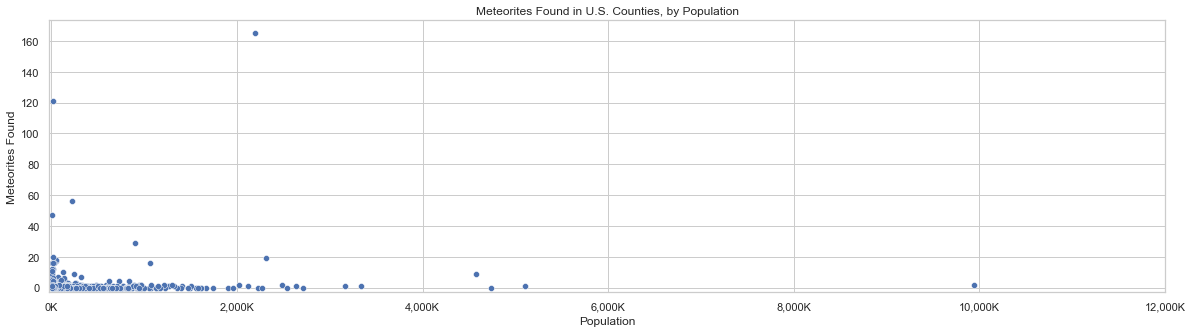

In [15]:
def graph_met_to_pop(us_county_data):
    ax = sns.scatterplot(data=us_county_data, x='population', y='meteorite_count')
    plt.title("Meteorites Found in U.S. Counties, by Population")
    plt.ylabel("Meteorites Found")
    plt.xlabel("Population")

    # Display the x labels in 1000's to improve readability
    xlabels = ['{:,.0f}'.format(x) + 'K' for x in ax.get_xticks()/1000]
    ax.set_xticks(ax.get_xticks())  ## Only do this to suppress warning about setting tick labels without setting ticks
    ax.set_xticklabels(xlabels)

    # Add a buffer to the left/bottom of the axes 
    plt.xlim(-25000)
    plt.ylim(-3)

graph_met_to_pop(us_county_data)

***
From this view, the most populous counties don't seem to have a large number of meteorite findings.  
In addition, some less-populated counties have quite a few meteorite findings.  
So far, our hypothesis is not looking good.  But the data is somewhat hard to see with the large number of counties with 1 or 2 meteorite findings.
Let's zoom in and only look at counties that found 7 or more meteorites.
***

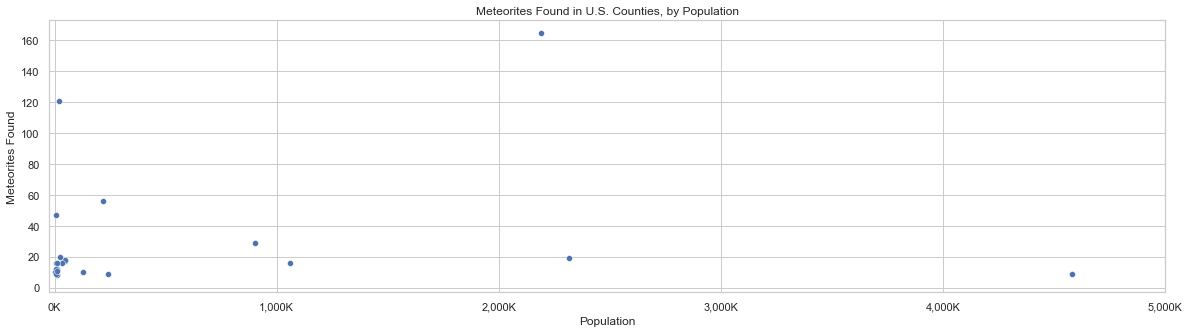

In [16]:
\
\
# Filter for meteorite counts greater than 7
graph_met_to_pop(us_county_data[us_county_data['meteorite_count'] > 7])

***
Zoomed in, we further see that counties with low populations still find a large number of meteorites.  
Our initial hypothesis does not appear to be true, at least for the United States.  
Let's zoom out globally and look for other patterns.
***

#### Correlate meteorites found to global location (country)

We will next look at the correlation between the number of meteorites found to a location on the earth.   
Since population has been tentatively ruled out based on the U.S. data, we will look at the global picture before forming a new hypothesis.  

We have the latitude and longitude of each meteorite found, so let's start with a global view of the landings.

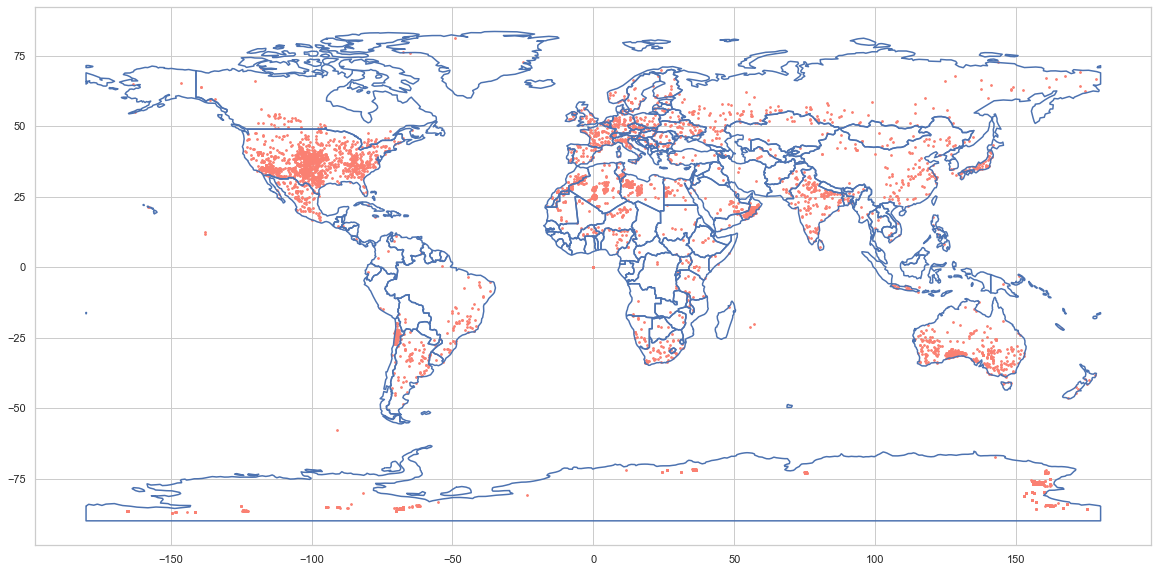

In [17]:
def build_mapping_data(meteorite_data):
    # Create lat/long points and add them to the meteorite data as a GeoDataFrame (gdf)
    # Next get the map of the earth (world) and return both
    geometry = [Point(xy) for xy in zip(meteorite_data['reclong'], meteorite_data['reclat'])]
    gdf = GeoDataFrame(meteorite_data, geometry=geometry)   
    world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

    return gdf, world

def display_world_view(gdf, world):
    # Plot the world map first
    ax = world.boundary.plot(figsize=(20, 12))

    # Plat the meteorite landings on top of the world map
    gdf.plot(ax=ax, marker='o', color='salmon', markersize=3)

gdf, world = build_mapping_data(meteorite_data)
display_world_view(gdf, world)

***
The results don't look entirely random.  Some countries seem to have more findings than others.  
Let's group the counts by country and look at the top 15 most frequent meteorite-finding countries.
***

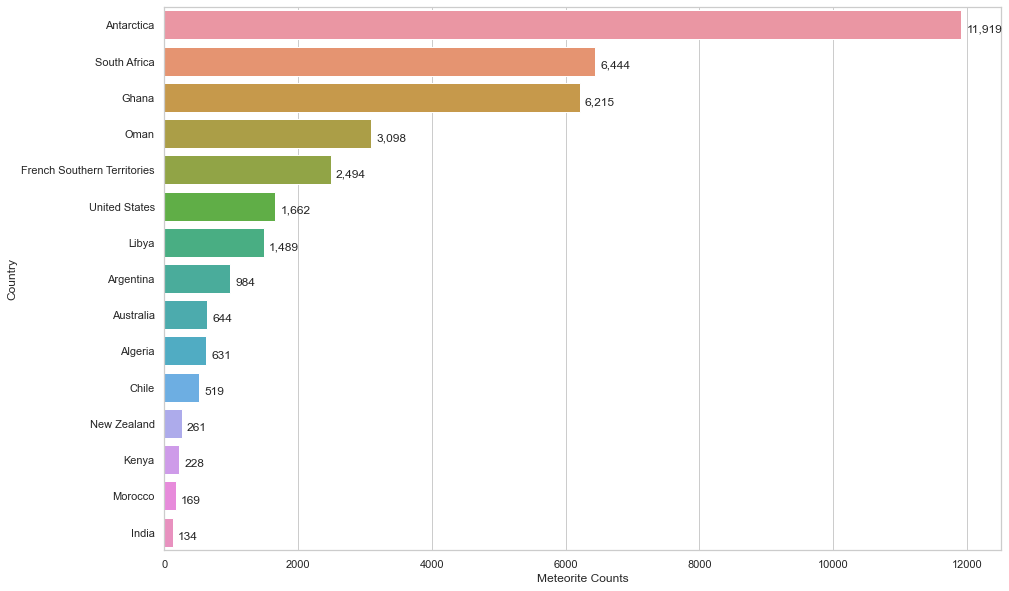

In [18]:
def graph_met_to_country(meteorite_data, top=50):
    # Group meteorite counts by country and select the top requested (default of 50) into a dataframe
    meteorite_counts = pd.DataFrame(meteorite_data.groupby(['country_name']).size().reset_index(name='meteorite_count'))
    meteorite_counts_top = meteorite_counts.sort_values(by='meteorite_count', ascending=False)[:top]

    # Plot the dataframe with meteorite count and country name
    plt.figure(figsize = (15,10))
    ax = sns.barplot(data=meteorite_counts_top, x='meteorite_count', y='country_name')

    # Add text to each bar with the number of meteorites for that country
    for p in ax.patches:
        pass
        _x = p.get_x() + p.get_width() + float(75)
        _y = p.get_y() + p.get_height() - (p.get_height()*0.25)
        value = '{:,.0f}'.format(p.get_width())
        ax.text(_x, _y, value, ha="left")

    # Label the axes
    ax.set_xlabel('Meteorite Counts')
    ax.set_ylabel('Country')

graph_met_to_country(meteorite_data, top=15)


***
Wow.  Now we are getting somewhere.  Some countries have a very large proportion of the total meteorites found.  
Let's look at this via a global heatmap.
***

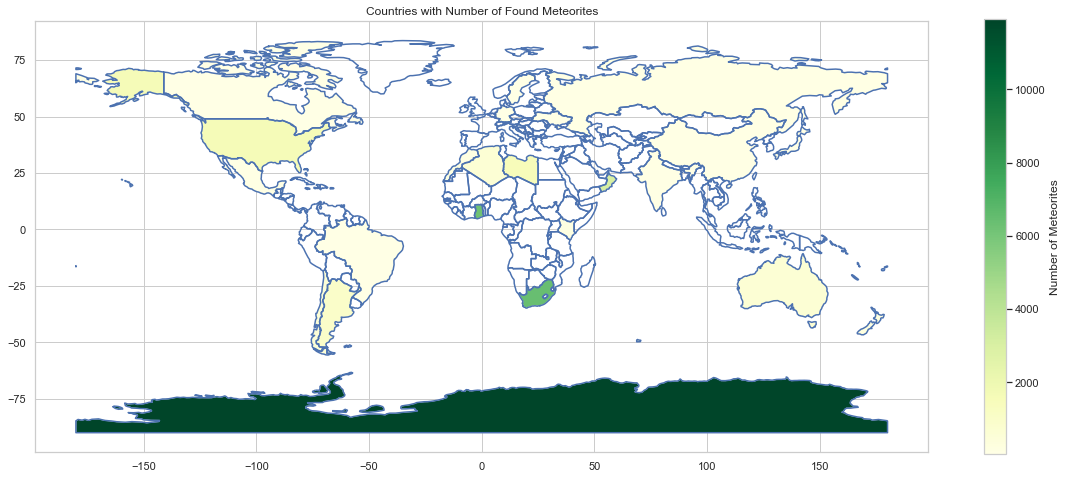

In [19]:
def map_met_to_country(gdf, world, meteorite_data, top=len(meteorite_data)):
    # If top wasn't passed in, we default to highest possible number of countries
    # Group meteorite counts by country_code_3 (which can join with GeoPandas data) and select the top requested countries into a dataframe
    meteorite_counts = pd.DataFrame(meteorite_data.groupby(['country_code_3']).size().reset_index(name='meteorite_count'))
    meteorite_counts_top = meteorite_counts.sort_values(by='meteorite_count', ascending=False)[:top]
    meteorite_counts_top.fillna(0)

    # Merge the meteorite_counts into the GeoPandas world dataset
    world_meteorites = world.merge(meteorite_counts_top, how='left', left_on=['iso_a3'], right_on=['country_code_3'])

    # First display the world map and then plot the meteorite counts
    ax=world['geometry'].boundary.plot(figsize=(20,16))
    world_meteorites.plot(column="meteorite_count", ax=ax, cmap='YlGn', 
                        legend=True, legend_kwds={"label": "Number of Meteorites", "orientation":"vertical", 'shrink': 0.5})

    # Set the title
    ax.set_title("Countries with Number of Found Meteorites")


map_met_to_country(gdf, world, meteorite_data, top=25)

#### Conclusion

There is clearly a pattern between the number of meteorites found and certain parts of the world.  
In particular, over 30% (11,919 / 38,400) of all meteorites have been found in Antarctica.  
A Google search on why this is true uncovered this analysis from Arizona State University (https://askanearthspacescientist.asu.edu/finding-meteorites)...
>A meteorite can land anywhere on the Earth’s surface, even in its vast oceans. But there are some places where it is easier to spot a meteorite. Some of the best places to find meteorites are dry and barren lands. Such places do not have much vegetation or forest cover to conceal the meteorite, and they don’t have much rain which would either wash or wear away the meteorite.  The top meteorite hunting places include Antarctica, the desert in the northwest region of the African continent, and the American Southwest. Antarctica is particularly cool (pun intended) because it is a desert of snow and ice, and a dark, weird looking rock from space would be easy to spot.

This aligns with our data analysis.  In fact, going back to our original review of meteorites in the U.S., the top seven counties were in Arizona, California, and Nevada -- all matching the "dry and barren lands" criteria.

***
### Afterthoughts

Although initial analysis of this data is complete, some further thoughts could make for interesting investigation...
 - Has the volume of found meteorites in Antarctic increased since it became known as a good spot for finding meteorites?  That is, is it somewhat self-fulfilling in that more people look in Antarctica because it's known for meteorite volume, which then increases meteorite volume?  
 - Can we better see the relationship between found meteorites and climate zones?  Climate zone identifications can be retrieved for lat/long coordinates with Scott Pinkelman's Climate API: http://climateapi.scottpinkelman.com/
 - Can we better see the disproportionate distribution of meteorite findings.  What % of all meteorites are found in just 3, 5, or 10 locations?

#### Meteorites found in Antarctica over time

A quick graph does not indicate a noted increase in yearly meteorite findings in Antarctica.  In fact, the findings are quite variable.

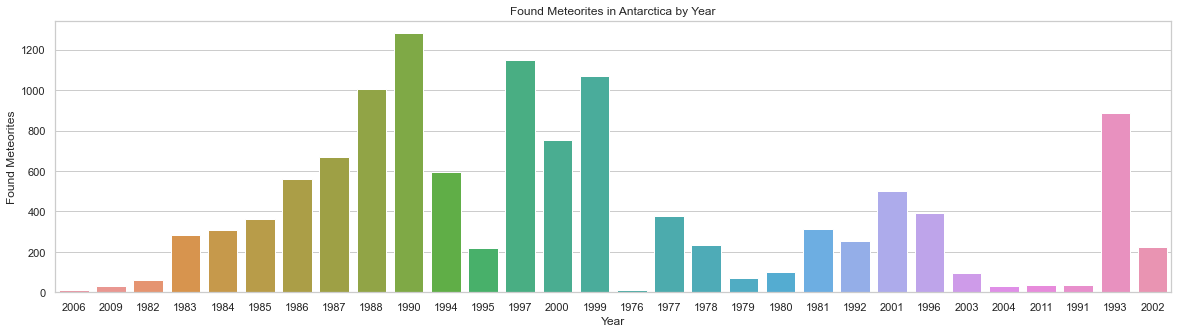

In [20]:
def graph_ant_met_by_year(meteorite_data):
    ax = sns.countplot(x='year', data=meteorite_data[meteorite_data['country_name'] == 'Antarctica'])
    ax.set_title("Found Meteorites in Antarctica by Year")
    ax.set_xlabel('Year')
    ax.set_ylabel('Found Meteorites')

graph_ant_met_by_year(meteorite_data)